# Installation

In [8]:
# @title Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
# @title Install Required Libraries
%%capture
!pip install albumentations opencv-python-headless Pillow roboflow ultralytics==8.0.134

In [3]:
# @title Import Required Libraries

# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Image Processing
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow

# Math and Data Manipulation
import numpy as np
import pandas as pd
import json

# XML Parsing
import xml.etree.ElementTree as ET

# PyTorch
import torch
import torchvision
import torch.utils as utils
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms.v2 as T
import torchvision.models.detection as detection
from torchvision.ops import box_iou

# Machine Learning Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_recall_fscore_support, accuracy_score,
                             classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, precision_recall_curve,
                             average_precision_score, roc_curve, auc,
                             RocCurveDisplay, PrecisionRecallDisplay)

# Utilities
import os
import random
import shutil
from tqdm import tqdm

# Typing
from typing import List, Tuple

# Roboflow
from roboflow import Roboflow

# Visualizations
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import pickle

In [4]:
# @title PyTorch Helper Functions
import subprocess

urls = [
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py"
]

for url in urls:
    subprocess.run(["wget", url])

from engine import train_one_epoch, evaluate
import utils


---

# Data Augmentation



In [ ]:
#-------------------------------------------------------------------------------
# Roboflow Annotation (Pascal VOC XML format)
#-------------------------------------------------------------------------------

'''
  The script begins by initializing the Roboflow API and downloading a specific dataset:
'''

# Initialize Roboflow with the provided API key
rf = Roboflow(api_key="YOUR API")

# Access the specific project and version from the workspace
project = rf.workspace("YOUR WORKSPACE NAME").project("YOUR DATASET NAME")
version = project.version(11)

# Download the dataset in Pascal VOC (XML) format
datasetvoc = version.download("voc")

'''
Also, you can Download the dataset in JASON or TXT format as below:
    In COCO (JSON) format:  dataset = version.download("coco")
    In YOLOv8 (TXT) format: dataset = version.download("yolov8")
'''

#-------------------------------------------------------------------------------
# Define output directory
#-------------------------------------------------------------------------------

'''
  The script sets up directories for storing the augmented images and
  their annotations, separated into training, validation, and test sets.
'''

# Set the path for the output directory where augmented images will be saved
output_directory = '/content/gdrive/MyDrive/YOUR-PATH/'

# Ensure the output directory exists; if not, create it
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Create directories for training, validation, and testing augmented images
output_train_dir = os.path.join(output_directory, 'train')
output_val_dir = os.path.join(output_directory, 'val')
output_test_dir = os.path.join(output_directory, 'test')

# Ensure all necessary directories exist
for directory in [output_train_dir, output_val_dir, output_test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

#-------------------------------------------------------------------------------
# Get all images and annotations paths from folders
#-------------------------------------------------------------------------------

# Initialize lists to hold paths of images and their corresponding annotations
image_paths = []
annotation_paths = []

# Walk through the dataset directory to collect image and annotation file paths
for root, _, files in os.walk(os.path.join(datasetvoc.location, 'train')):
    for file in files:
        if file.endswith('.jpg'):  # Check for image files
            image_paths.append(os.path.join(root, file))
            annotation_paths.append(os.path.join(root, file.replace('.jpg', '.xml')))  # Corresponding annotation file

#-------------------------------------------------------------------------------
# Function to load image and labels
#-------------------------------------------------------------------------------

def load_image_and_labels(image_path, annotation_path):
    """
    Load an image and its labels from the given paths.
    -> This function reads the image using OpenCV and parses the XML annotation file
       to extract bounding boxes and labels for each object in the image.

    Args:
    image_path (str): Path to the image file.
    annotation_path (str): Path to the annotation file.

    Returns:
    image (numpy.ndarray): The loaded image.
    boxes (list): List of bounding boxes.
    labels (list): List of labels for each bounding box.
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Read the annotation XML file
    with open(annotation_path) as f:
        data = f.read()
    root = ET.fromstring(data)

    # Parse the XML to extract bounding boxes and labels
    boxes, labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        bbox = [
            int(bndbox.find('xmin').text),
            int(bndbox.find('ymin').text),
            int(bndbox.find('xmax').text),
            int(bndbox.find('ymax').text)
        ]
        boxes.append(bbox)
        labels.append(label)

    return image, boxes, labels

#-------------------------------------------------------------------------------
# Function to create augmentation pipeline
#-------------------------------------------------------------------------------

def _create_augmentation_pipeline(include_rotate=True) -> A.Compose:
    """
    Create an augmentation pipeline using Albumentations.

    Args:
    include_rotate (bool): Whether to include random 90-degree rotations.

    Returns:
    A.Compose: The composed augmentation pipeline.
    """
    # Define the list of transformations
    transforms = [
        A.HorizontalFlip(p=0.5),                                                                  # Flip horizontally with a 50% probability
        A.VerticalFlip(p=0.5),                                                                    # Flip vertically with a 50% probability
        A.HueSaturationValue(hue_shift_limit=12, sat_shift_limit=17, val_shift_limit=12, p=0.4),  # Apply Hue, Saturation, and Value shifts with a 40% probability
        A.Posterize(p=0.5),                                                                       # Apply posterization with a 50% probability
        A.GaussianBlur(p=0.3),                                                                    # Apply Gaussian blur with a 30% probability
        A.Blur(blur_limit=3, p=0.3),                                                              # Apply blur with a 30% probability
        A.GaussNoise(p=0.5),                                                                      # Apply Gaussian noise with a 50% probability
        A.Downscale(scale_min=0.25, scale_max=0.75, p=0.3),                                       # Randomly downscale images with a scale factor between 0.25 and 0.75 with a 30% probability
        A.MultiplicativeNoise(p=0.3),                                                             # Apply multiplicative noise with a 30% probability
        A.RandomBrightnessContrast(p=0.5, brightness_limit=0.2, contrast_limit=0.2),              # Randomly adjust brightness and contrast with limits of 0.2 with a 50% probability
        A.ISONoise(p=0.1),                                                                        # Apply ISO noise with a 10% probability
    ]
    if include_rotate:
        transforms.append(A.RandomRotate90(p=0.7))                                                # Rotate images randomly by 90 degrees with a 70% probability
    return A.Compose(transforms, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Create two augmentation pipelines: one with rotation and one without
transform = _create_augmentation_pipeline(include_rotate=True)
transform2 = _create_augmentation_pipeline(include_rotate=False)

#-------------------------------------------------------------------------------
# Perform data augmentation and save augmented images and annotations
#-------------------------------------------------------------------------------

# Number of augmentations to perform per image
num_augmentations = 100

# Iterate over each image and its annotation
for image_path, annotation_path in zip(image_paths, annotation_paths):
    for i in range(num_augmentations):
        # Load image and its bounding boxes and labels
        image, bboxes, labels = load_image_and_labels(image_path, annotation_path)

        # Apply different augmentation pipelines based on image name
        if 'Box' in image_path or 'CBox' in image_path:
            augmented = transform2(image=image, bboxes=bboxes, labels=labels)
        else:
            augmented = transform(image=image, bboxes=bboxes, labels=labels)

        # Extract augmented image and its annotations
        augmented_image = augmented['image']
        augmented_boxes = augmented['bboxes']
        augmented_labels = augmented['labels']

        # Save the augmented image
        augmented_image_path = os.path.join(output_directory, f"{os.path.basename(image_path).split('.')[0]}_aug_{i}.jpg")
        cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

        # Save the augmented annotations in Pascal VOC (XML) format
        annotation_save_path = augmented_image_path.replace('.jpg', '.xml')
        root = ET.Element("annotation")

        for bbox, label in zip(augmented_boxes, augmented_labels):
            object_elem = ET.SubElement(root, "object")
            name_elem = ET.SubElement(object_elem, "name")
            name_elem.text = label

            bndbox_elem = ET.SubElement(object_elem, "bndbox")
            xmin_elem = ET.SubElement(bndbox_elem, "xmin")
            ymin_elem = ET.SubElement(bndbox_elem, "ymin")
            xmax_elem = ET.SubElement(bndbox_elem, "xmax")
            ymax_elem = ET.SubElement(bndbox_elem, "ymax")

            xmin_elem.text = str(int(bbox[0]))
            ymin_elem.text = str(int(bbox[1]))
            xmax_elem.text = str(int(bbox[2]))
            ymax_elem.text = str(int(bbox[3]))

        tree = ET.ElementTree(root)
        tree.write(annotation_save_path)

#-------------------------------------------------------------------------------
# Split dataset into train, validation, and test sets
#-------------------------------------------------------------------------------

# Collect all augmented images and their corresponding annotation paths
augmented_images = [os.path.join(output_directory, f) for f in os.listdir(output_directory) if f.endswith('.jpg')]
augmented_annotations = [f.replace('.jpg', '.xml') for f in augmented_images]

# Split data into 60% training, 20% validation, and 20% test sets
train_images, test_images, train_annotations, test_annotations = train_test_split(
    augmented_images, augmented_annotations, test_size=0.2, random_state=42)

train_images, val_images, train_annotations, val_annotations = train_test_split(
    train_images, train_annotations, test_size=0.25, random_state=42)

def move_files(file_paths, dest_dir):
    """
    Move files to the specified directory.

    Args:
    file_paths (list): List of file paths to move.
    dest_dir (str): Destination directory.
    """
    for file_path in file_paths:
        shutil.move(file_path, dest_dir)

# Move training, validation, and test files to their respective directories
move_files(train_images + train_annotations, output_train_dir)
move_files(val_images + val_annotations, output_val_dir)
move_files(test_images + test_annotations, output_test_dir)
#-------------------------------------------------------------------------------


---

# Data Preparation

In [ ]:
# @title Data Loader Class

# Based on this Tutorial -> https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

#-------------------------------------------------------------------------------
class ChocolateDataset(Dataset):
    """
    A custom Dataset class for loading chocolate image data and annotations and
    preparing the data for object detection tasks using PyTorch.
    """

    def __init__(self, image_dir, transforms=None):
        """
        Initialize the ChocolateDataset.

        Args:
            image_dir (str): Directory containing the image and annotation files.
            transforms (callable, optional): Optional transforms to be applied on the images.
        """
        self.image_dir = image_dir
        self.transforms = transforms

        # Load all image files, sorting them to ensure alignment with annotations
        self.images = list(sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')]))
        self.annotations = [f.replace('.jpg', '.xml') for f in self.images]

    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Retrieve and prepare a single data item from the dataset.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: (image, target) where target is a dictionary containing object detection annotations.
        """
        # Load image and annotation files
        img_path = os.path.join(self.image_dir, self.images[idx])
        annotation_path = os.path.join(self.image_dir, self.annotations[idx])

        # Read image using OpenCV and convert from BGR to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Parse the XML annotation file
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []
        # Iterate over each object in the XML annotation
        for member in root.findall('object'):
            label = member.find('name').text
            xmin = int(member.find('bndbox').find('xmin').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        # Convert labels to integers
        # 8 Classes + 1 Background Class
        # Note: 0 is reserved for background class in many object detection frameworks
        label_to_int = {
            'Box': 1, 'Diamond': 2, 'DomenicaBlack': 3, 'DomenicaBlue': 4,
            'Section': 5, 'Shoniz': 6, 'Tickers': 7, 'Triperz': 8
        }
        int_labels = [label_to_int[label] for label in labels]

        # Convert annotations to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(int_labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  # Calculate bounding box areas
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)       # Assume no crowd instances

        # Prepare the final target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transforms if any
        if self.transforms:
            img = self.transforms(img)

        return img, target

# Define the image transformation pipeline
transform = T.Compose([
    T.ToImage(),  # Convert to PIL Image
    T.ToDtype(torch.float32, scale=True)  # Convert to float32 tensor and scale to [0, 1]
])
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Directory paths for train, validation, and test datasets
#-------------------------------------------------------------------------------
train_dir = '/content/gdrive/MyDrive/YOUR-PATH/train'
val_dir = '/content/gdrive/MyDrive/YOUR-PATH/val'
test_dir = '/content/gdrive/MyDrive/YOUR-PATH/test'
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Create dataset instances
#-------------------------------------------------------------------------------
train_dataset = ChocolateDataset(image_dir=train_dir, transforms=transform)
val_dataset = ChocolateDataset(image_dir=val_dir, transforms=transform)
test_dataset = ChocolateDataset(image_dir=test_dir, transforms=transform)
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Define data loaders
#-------------------------------------------------------------------------------
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=utils.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=utils.collate_fn)
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Convert ChocolateDataset to a pandas DataFrame
#-------------------------------------------------------------------------------
def dataset_to_dataframe(dataset):
    """
    Convert a ChocolateDataset to a pandas DataFrame.

    -> This function is useful for analysis and debugging purposes.

    Args:
        dataset (ChocolateDataset): The dataset to convert.

    Returns:
        pd.DataFrame: A DataFrame containing the dataset information.
    """
    label_to_int = {
        'Box': 1, 'Diamond': 2, 'Domenica Black': 3, 'Domenica Blue': 4,
        'Section': 5, 'Shoniz': 6, 'Tickers': 7, 'Triperz': 8
    }
    data = []
    for idx in tqdm(range(len(dataset)), desc="Converting dataset to DataFrame"):
        img, target = dataset[idx]
        for box, label in zip(target['boxes'], target['labels']):
            label_str = list(label_to_int.keys())[list(label_to_int.values()).index(label.item())]
            data.append({
                'image_id': target['image_id'].item(),
                'image_path': dataset.images[idx],
                'xmin': box[0].item(),
                'ymin': box[1].item(),
                'xmax': box[2].item(),
                'ymax': box[3].item(),
                'intlabel': label.item(),
                'orglabel': label_str,
            })
    return pd.DataFrame(data)

train_df = dataset_to_dataframe(train_dataset)
val_df = dataset_to_dataframe(val_dataset)
test_df = dataset_to_dataframe(test_dataset)
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Save DataFrames as CSV files
#-------------------------------------------------------------------------------
train_df.to_csv(os.path.join(train_dir, 'train.csv'), index=False)
val_df.to_csv(os.path.join(val_dir, 'val.csv'), index=False)
test_df.to_csv(os.path.join(test_dir, 'test.csv'), index=False)
#-------------------------------------------------------------------------------

In [14]:
# @markdown **Display the Train set**

num_unique_image_id = train_df['image_id'].nunique()
print("Number of Train data:", num_unique_image_id)
print("\nFrequency of each objects:\n", train_df['orglabel'].value_counts())
train_df

Number of Train data': 832

Frequency of each objects:
 orglabel
Section           1206
Shoniz             469
Diamond            396
Domenica Black     395
Tickers            387
Triperz            379
Domenica Blue      266
Box                201
Name: count, dtype: int64


,image_id,image_path,xmin,ymin,xmax,ymax,intlabel,orglabel
0,[tensor(0)],All_Chocolates_JPG_aug_0.jpg,137.0,68.0,205.0,139.0,6,Shoniz
1,[tensor(0)],All_Chocolates_JPG_aug_0.jpg,271.0,36.0,304.0,185.0,3,Domenica Black
2,[tensor(0)],All_Chocolates_JPG_aug_0.jpg,277.0,261.0,321.0,405.0,4,Domenica Blue
3,[tensor(0)],All_Chocolates_JPG_aug_0.jpg,389.0,65.0,506.0,224.0,7,Tickers
4,[tensor(0)],All_Chocolates_JPG_aug_0.jpg,433.0,309.0,502.0,376.0,2,Diamond
...,...,...,...,...,...,...,...,...
3694,[tensor(827)],Triperz_Front_jpg_aug_91.jpg,175.0,249.0,255.0,361.0,8,Triperz
3695,[tensor(828)],Triperz_Front_jpg_aug_93.jpg,279.0,175.0,391.0,255.0,8,Triperz
3696,[tensor(829)],Triperz_Front_jpg_aug_96.jpg,175.0,249.0,255.0,361.0,8,Triperz
3697,[tensor(830)],Triperz_Front_jpg_aug_97.jpg,279.0,167.0,391.0,247.0,8,Triperz


In [18]:
# @markdown **Display the Validation set**

num_unique_image_id = val_df['image_id'].nunique()
print("Number of Validation data:", num_unique_image_id)
print("\nFrequency of each objects:\n", val_df['orglabel'].value_counts())
val_df

Number of Validation data: 208

Frequency of each objects:
 orglabel
Section           270
Shoniz            106
Triperz           101
Diamond            95
Domenica Black     92
Tickers            91
Domenica Blue      61
Box                45
Name: count, dtype: int64


,image_id,image_path,xmin,ymin,xmax,ymax,intlabel,orglabel
0,[tensor(0)],All_Chocolates_JPG_aug_11.jpg,435.0,67.0,503.0,139.0,6,Shoniz
1,[tensor(0)],All_Chocolates_JPG_aug_11.jpg,336.0,35.0,369.0,185.0,3,Domenica Black
2,[tensor(0)],All_Chocolates_JPG_aug_11.jpg,319.0,261.0,363.0,405.0,4,Domenica Blue
3,[tensor(0)],All_Chocolates_JPG_aug_11.jpg,134.0,64.0,251.0,224.0,7,Tickers
4,[tensor(0)],All_Chocolates_JPG_aug_11.jpg,137.0,309.0,207.0,376.0,2,Diamond
...,...,...,...,...,...,...,...,...
856,[tensor(203)],Triperz_Front_jpg_aug_82.jpg,249.0,175.0,361.0,255.0,8,Triperz
857,[tensor(204)],Triperz_Front_jpg_aug_87.jpg,167.0,279.0,247.0,391.0,8,Triperz
858,[tensor(205)],Triperz_Front_jpg_aug_9.jpg,279.0,167.0,391.0,247.0,8,Triperz
859,[tensor(206)],Triperz_Front_jpg_aug_94.jpg,175.0,249.0,255.0,361.0,8,Triperz


In [17]:
# @markdown **Display the Test set**

num_unique_image_id = test_df['image_id'].nunique()
print("Number of Test data:", num_unique_image_id)
print("\nFrequency of each objects:\n", test_df['orglabel'].value_counts())
test_df

Number of Test data: 260

Frequency of each objects:
 orglabel
Section           324
Shoniz            125
Tickers           122
Triperz           120
Domenica Black    113
Diamond           109
Domenica Blue      73
Box                54
Name: count, dtype: int64


,image_id,image_path,xmin,ymin,xmax,ymax,intlabel,orglabel
0,[tensor(0)],All_Chocolates_JPG_aug_1.jpg,341.0,137.0,412.0,205.0,6,Shoniz
1,[tensor(0)],All_Chocolates_JPG_aug_1.jpg,294.0,271.0,444.0,304.0,3,Domenica Black
2,[tensor(0)],All_Chocolates_JPG_aug_1.jpg,75.0,277.0,219.0,321.0,4,Domenica Blue
3,[tensor(0)],All_Chocolates_JPG_aug_1.jpg,256.0,389.0,415.0,506.0,7,Tickers
4,[tensor(0)],All_Chocolates_JPG_aug_1.jpg,104.0,433.0,170.0,502.0,2,Diamond
...,...,...,...,...,...,...,...,...
1035,[tensor(255)],Triperz_Front_jpg_aug_74.jpg,167.0,249.0,247.0,361.0,8,Triperz
1036,[tensor(256)],Triperz_Front_jpg_aug_75.jpg,279.0,167.0,391.0,247.0,8,Triperz
1037,[tensor(257)],Triperz_Front_jpg_aug_90.jpg,249.0,167.0,361.0,247.0,8,Triperz
1038,[tensor(258)],Triperz_Front_jpg_aug_92.jpg,279.0,167.0,391.0,247.0,8,Triperz


# Training Phase

In [19]:
# @title The Faster RCNN Model

def get_model(num_classes):
    """
    Load a pre-trained Faster R-CNN model and modify it for our dataset.

    Args:
        num_classes (int): The number of classes in our dataset (including background).

    Returns:
        torchvision.models.detection.FasterRCNN: Modified Faster R-CNN model.
    """
    # Load a pre-trained Faster R-CNN model with ResNet-50 backbone and Feature Pyramid Network (FPN)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Define the number of classes (including the background)
num_classes = 8 + 1  # 8 object classes + 1 background class

# Get the modified Faster R-CNN model
model = get_model(num_classes)

# Set up the device for training (GPU if available, otherwise CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)  # Move the model to the appropriate device

# Define the optimizer
# We only optimize parameters that require gradients
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Define the learning rate scheduler
# This will decrease the learning rate by a factor of 0.1 every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 110MB/s] 


In [ ]:
# @title Training loop

# Define training parameters
num_epochs = 10
checkpoint_freq = 3  # Save checkpoint every 3 epochs
checkpoint_dir = '/content/gdrive/MyDrive/YOUR-PATH/checkpoint/'  # Directory to save checkpoints
os.makedirs(checkpoint_dir, exist_ok=True)

# List to store training metrics for each epoch
metrics = []

# Main training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train for one epoch
    metric_logger = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=20)
    metrics.append(metric_logger)

    # Update the learning rate
    lr_scheduler.step()

    # Evaluate the model on the validation dataset
    print("Evaluating on validation set...")
    evaluate(model, val_loader, device=device)

    # Save checkpoint at specified frequency
    if (epoch + 1) % checkpoint_freq == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch+1}.pth')

        # Prepare checkpoint dictionary
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'epoch': epoch
        }

        # Save the checkpoint
        torch.save(checkpoint, checkpoint_path)
        print(f'Saved checkpoint at epoch {epoch+1} to {checkpoint_path}')

print("Training completed.")

In [ ]:
# @title Load checkpoint

# Configuration for checkpointing
checkpoint_freq = 3  # Save checkpoint every 3 epochs
checkpoint_dir = '/content/gdrive/MyDrive/YOUR-PATH/checkpoint/'  # Directory to save checkpoints
os.makedirs(checkpoint_dir, exist_ok=True)

# Path to the checkpoint we want to load
checkpoint_path = '/content/gdrive/MyDrive/YOUR-PATH/checkpoint/epoch_12.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Restore model state
model.load_state_dict(checkpoint['model_state_dict'])

# Restore optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Restore learning rate scheduler state
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

# Determine the starting epoch for resumed training
start_epoch = checkpoint['epoch'] + 1  # +1 because epoch is 0-indexed

print(f'Loaded checkpoint from epoch {start_epoch}')

# Configuration for resumed training
num_epochs = 12  # Total number of epochs to train

# Resume training loop
for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train for one epoch
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=20)

    # Update the learning rate
    lr_scheduler.step()

    # Evaluate the model on the validation dataset
    print("Evaluating on validation set...")
    evaluate(model, val_loader, device=device)

    # Save checkpoint at specified frequency
    if (epoch + 1) % checkpoint_freq == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch+1}.pth')

        # Prepare checkpoint dictionary
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'epoch': epoch
        }

        # Save the checkpoint
        torch.save(checkpoint, checkpoint_path)
        print(f'Saved checkpoint at epoch {epoch+1} to {checkpoint_path}')

print("Resumed training completed.")

In [ ]:
# @title Save the Model
final_model_path = '/content/gdrive/MyDrive/YOUR-PATH/FinalModel/'
os.makedirs(final_model_path, exist_ok=True)

torch.save(model.state_dict(), os.path.join(final_model_path, 'faster_rcnn_v1.pth'))
print(f'...:News:... \n Woohoo The Final Model has landed safely in {final_model_path}. \n Confetti and champagne are in order... Lets party with robots :)) ')

---

# Evaluation Phase

In [ ]:
# @title Load the Model

def load_model(model_path: str, num_classes: int) -> torch.nn.Module:
    """
    Load a Faster R-CNN model with a custom number of classes.

    Args:
        model_path (str): Path to the saved model weights.
        num_classes (int): Number of classes the model should predict (including background).

    Returns:
        torch.nn.Module: Loaded and configured Faster R-CNN model.
    """
    # Initialize the Faster R-CNN model with a ResNet-50 backbone
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)

    # Modify the classifier to match the desired number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Set the device (GPU if available, otherwise CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Load the model weights
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Set the model to evaluation mode
    model.eval()

    return model

# Configuration
MODEL_PATH = '/content/gdrive/MyDrive/YOUR-PATH/FinalModel/faster_rcnn_v1.pth'
NUM_CLASSES = 9  # 8 classes + 1 background

# Load the model
model = load_model(MODEL_PATH, NUM_CLASSES)
print("Model loaded successfully!")

In [ ]:
# @title Evaluate the Model

def nms(boxes: torch.Tensor, scores: torch.Tensor, iou_threshold: float) -> torch.Tensor:
    """
    Perform Non-Maximum Suppression (NMS) on the bounding boxes.

    Args:
        boxes (torch.Tensor): Tensor of bounding boxes.
        scores (torch.Tensor): Tensor of confidence scores.
        iou_threshold (float): IoU threshold for NMS.

    Returns:
        torch.Tensor: Indices of boxes to keep after NMS.
    """
    return torchvision.ops.nms(boxes, scores, iou_threshold)

def evaluate_model_with_nms(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader,
                            device: torch.device, iou_threshold: float = 0.75) -> tuple:
    """
    Evaluate the object detection model using Non-Maximum Suppression.

    Args:
        model (torch.nn.Module): The object detection model to evaluate.
        data_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to run the evaluation on.
        iou_threshold (float, optional): IoU threshold for NMS. Defaults to 0.75.

    Returns:
        tuple: Arrays of actual labels, predicted labels, confidence scores, and IoU values.
    """
    model.eval()
    all_labels, all_preds, all_scores, iou_list = [], [], [], []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

            for i, output in enumerate(outputs):
                labels = targets[i]['labels'].cpu().numpy()
                actual_boxes = targets[i]['boxes'].cpu()

                predicted_boxes = output['boxes'].detach().cpu()
                scores = output['scores'].detach().cpu()
                preds = output['labels'].detach().cpu()

                # Apply NMS
                keep = nms(predicted_boxes, scores, iou_threshold)
                predicted_boxes = predicted_boxes[keep]
                scores = scores[keep]
                preds = preds[keep]

                # Calculate IoU between actual and predicted boxes
                iou_matrix = box_iou(actual_boxes, predicted_boxes)
                matched_pred_indices = iou_matrix.max(dim=1)[1]

                # Sort predictions according to actual labels
                sorted_preds = preds[matched_pred_indices]
                sorted_scores = scores[matched_pred_indices]

                all_labels.extend(labels)
                all_preds.extend(sorted_preds.numpy())
                all_scores.extend(sorted_scores.numpy())
                iou_list.extend(iou_matrix.max(dim=1)[0].numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_scores), np.array(iou_list)

def main(model: torch.nn.Module, test_loader: torch.utils.data.DataLoader,
         device: torch.device, output_path: str):
    """
    Main function to run the evaluation and save results.

    Args:
        model (torch.nn.Module): The object detection model to evaluate.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to run the evaluation on.
        output_path (str): Path to save the evaluation results CSV.
    """
    # Run evaluation with NMS
    labels, preds, scores, iou_list = evaluate_model_with_nms(model, test_loader, device)

    # Create and save the DataFrame to a CSV file
    eval_df = pd.DataFrame({
        'Actual Labels': labels,
        'Predicted Labels': preds,
        'Scores': scores,
        'IoU': iou_list
    })
    eval_df.to_csv(output_path, index=False)
    print(f"Evaluation results saved to {output_path}")

if __name__ == "__main__":
    model = None
    test_loader = None
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    output_path = '/content/gdrive/MyDrive/YOUR-PATH/FinalModel/evaluation_results.csv'

    main(model, test_loader, device, output_path)

In [ ]:
# @title Classification Report

def load_evaluation_results(file_path: str) -> pd.DataFrame:
    """
    Load the evaluation results from a CSV file.

    Args:
        file_path (str): Path to the CSV file containing evaluation results.

    Returns:
        pd.DataFrame: DataFrame containing the evaluation results.
    """
    return pd.read_csv(file_path)

def generate_classification_report(labels: pd.Series, predictions: pd.Series, class_names: list) -> str:
    """
    Generate a classification report.

    Args:
        labels (pd.Series): Actual labels.
        predictions (pd.Series): Predicted labels.
        class_names (list): List of class names.

    Returns:
        str: Classification report as a string.
    """
    return classification_report(labels, predictions, target_names=class_names)


# Load evaluation results
file_path = '/content/gdrive/MyDrive/YOUR-PATH/FinalModel/evaluation_results.csv'
eval_df = load_evaluation_results(file_path)

# Extract labels and predictions
labels = eval_df['Actual Labels'].values
preds = eval_df['Predicted Labels'].values
scores = eval_df['Scores'].values
iou_list = eval_df['IoU'].values

# Define class names
class_names = ['Box', 'Diamond', 'Domenica Black', 'Domenica Blue', 'Section', 'Shoniz', 'Tickers', 'Triperz']

# Generate and print classification report
report = generate_classification_report(labels, preds, class_names)
print('Classification Report:\n', report)

In [ ]:
# @title Plots
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Set ggplot style
plt.style.use('seaborn-darkgrid')

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names, save_path=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names, linewidths=.5, cbar_kws={"shrink": .8})
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16, weight='bold')
    plt.xticks(rotation=45, ha='right',fontsize=12)
    plt.yticks(fontsize=12)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.show()
    else:
        plt.show()

# Function to plot precision-recall curve for each class
def plot_precision_recall_curve(test_labels, test_scores, class_names, color_map=None, save_path=None):
    plt.figure(figsize=(8, 6))
    if color_map is None:
        color_map = {
            'Box': 'green',
            'Diamond': 'gold',
            'Domenica Black': 'black',
            'Domenica Blue': 'blue',
            'Section': 'cyan',
            'Shoniz': 'pink',
            'Tickers': 'red',
            'Triperz': 'gold'
        }

    for i in range(len(class_names)):
        if np.sum(test_labels == i) == 0:
            # Skip classes with no positive samples
            continue
        precision, recall, _ = precision_recall_curve(test_labels == i, test_scores[:, i])
        average_precision = average_precision_score(test_labels == i, test_scores[:, i])
        class_name = class_names[i]
        plt.plot(recall, precision, lw=2, color=color_map.get(class_name, 'b'), label=f'{class_name} (AP={average_precision:.2f})')

    # Set labels and title
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Precision-Recall Curve', fontsize=16, weight='bold')

    # Customize the legend
    plt.legend(loc='best', fontsize=10, frameon=True, fancybox=True, shadow=True, borderpad=1)
    plt.grid(False)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.show()
    else:
        plt.show()

# Function to plot ROC curve for each class
def plot_roc_curve(test_labels, test_scores, class_names, color_map=None, save_path=None):
    plt.figure(figsize=(8, 6))
    if color_map is None:
        color_map = {
            'Box': 'green',
            'Diamond': 'gold',
            'Domenica Black': 'black',
            'Domenica Blue': 'blue',
            'Section': 'cyan',
            'Shoniz': 'pink',
            'Tickers': 'red',
            'Triperz': 'gold'
        }

    for i in range(len(class_names)):
        if np.sum(test_labels == i) == 0:
            # Skip classes with no positive samples
            continue
        fpr, tpr, _ = roc_curve(test_labels == i, test_scores[:, i])
        roc_auc = auc(fpr, tpr)
        class_name = class_names[i]
        plt.plot(fpr, tpr, lw=2, color=color_map.get(class_name, 'b'), label=f'{class_name} (AUC={roc_auc:.2f})')

    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')

    # Set labels and title
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve', fontsize=16, weight='bold')

    # Customize the legend
    plt.legend(loc='best', fontsize=10, frameon=True, fancybox=True, shadow=True, borderpad=1)

    plt.grid(False)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.show()
    else:
        plt.show()

# Function to plot IoU distribution
def plot_iou_distribution(iou_list, save_path=None):
    plt.figure(figsize=(8, 6))
    sns.histplot(iou_list, bins=50, kde=True, color='purple')
    plt.xlabel('IoU', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('IoU Distribution', fontsize=16, weight='bold')
    plt.grid(False)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.show()
    else:
        plt.show()

# Function to plot detection score distribution with a magnifier
def plot_detection_score_distribution(test_scores, save_path=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(test_scores, bins=50, kde=True, color='teal', ax=ax)
    ax.set_xlabel('Detection Score', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_title('Detection Score Distribution', fontsize=16,weight='bold')
    plt.grid(False)

    # Create an inset plot for the focused range
    ax_inset = inset_axes(ax, width="40%", height="40%", loc="center")
    sns.histplot(test_scores, bins=50, kde=True, color='teal', ax=ax_inset)
    ax_inset.set_xlim(0.965, 0.99)
    ax_inset.set_ylim(0, 60)
    ax_inset.set_title('Zoomed in 0.97-0.99', fontsize=10, weight='bold')
    ax_inset.set_ylabel('Frequency', fontsize=8)
    ax_inset.tick_params(axis='both', which='major', labelsize=10)
    ax_inset.grid(False)

    # Mark the inset on the main plot
    mark_inset(ax, ax_inset, loc1=1, loc2=3, fc="none", ec="0.5")

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.show()
    else:
        plt.show()

# Function to calculate mAP
def calculate_map(test_labels, test_scores, class_names):
    average_precisions = []
    for i in range(len(class_names)):
        if np.sum(test_labels == i) == 0:
            # No true positive for this class, skip it
            continue
        precision, recall, _ = precision_recall_curve(test_labels == i, test_scores[:, i])
        average_precision = average_precision_score(test_labels == i, test_scores[:, i])
        average_precisions.append(average_precision)
    mAP = np.mean(average_precisions)
    return mAP

plot_path = '/content/gdrive/MyDrive/YOUR-PATH/FasterRCNN/FinalModel/'

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(labels, preds)
plot_confusion_matrix(conf_matrix, class_names, save_path= os.path.join(plot_path, 'confusion_matrix.png'))

class_names2 = ['_','Box', 'Diamond', 'Domenica Black', 'Domenica Blue', 'Section', 'Shoniz', 'Tickers', 'Triperz']

# Plot precision-recall curve
n_classes = len(class_names2)
test_scores_multiclass = np.zeros((len(labels), n_classes))
for i, score in enumerate(scores):
    test_scores_multiclass[i, preds[i]] = score

print("-"*70)
plot_precision_recall_curve(labels, test_scores_multiclass, class_names2, save_path= os.path.join(plot_path, 'precision_recall_curve.png'))
print("-"*70)
plot_roc_curve(labels, test_scores_multiclass, class_names2, save_path= os.path.join(plot_path, 'roc_curve.png'))
print("-"*70)
plot_iou_distribution(iou_list, save_path= os.path.join(plot_path, 'iou_distribution.png'))
print("-"*70)
plot_detection_score_distribution(scores, save_path= os.path.join(plot_path, 'detection_score_distribution.png'))
print("-"*70)

# Calculate and print mAP
mAP = calculate_map(labels, test_scores_multiclass, class_names2)
print(f'The Mean Average Precision (mAP) is: {mAP:.2f}')

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------


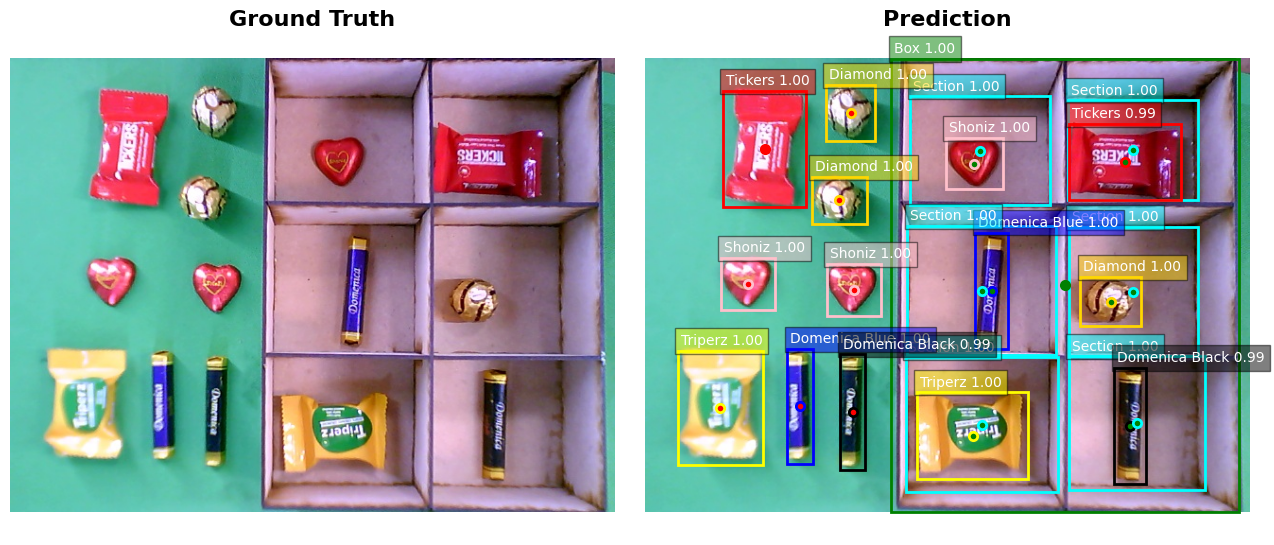

In [ ]:
# @title Detection example

# Define the label map for each classes
label_map = {
    1: 'Box',
    2: 'Diamond',
    3: 'Domenica Black',
    4: 'Domenica Blue',
    5: 'Section',
    6: 'Shoniz',
    7: 'Tickers',
    8: 'Triperz'
}

# Define the color map for each label
color_map = {
    'Box': 'green',
    'Diamond': 'gold',
    'Domenica Black': 'black',
    'Domenica Blue': 'blue',
    'Section': 'cyan',
    'Shoniz': 'pink',
    'Tickers': 'red',
    'Triperz': 'yellow'
}

def plot_sample(image, output, label_map, color_map, detection_threshold=0.8):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0.05)

    # Convert image to NumPy array for Matplotlib
    img_np = image.permute(1, 2, 0).cpu().numpy()

    # Plot ground truth
    axs[0].imshow(img_np)
    axs[0].set_title("Ground Truth", fontsize=16, fontweight='bold', y=1.05)
    axs[0].axis('off')

    # Filter predictions based on the detection threshold
    boxes = output['boxes'].data.cpu().numpy()
    scores = output['scores'].data.cpu().numpy()
    labels = output['labels'].data.cpu().numpy()
    filtered_boxes = boxes[scores >= detection_threshold].astype(np.int32)
    filtered_labels = labels[scores >= detection_threshold]
    filtered_scores = scores[scores >= detection_threshold]

    # Dictionaries to hold center points and their labels
    inside_box_centers = {label_map[label]: [] for label in label_map.keys()}
    outside_box_centers = {label_map[label]: [] for label in label_map.keys()}

    # Find the bounding box labeled as 'Box'
    box_label_boxes = filtered_boxes[filtered_labels == 1]

    # Plot prediction
    axs[1].imshow(img_np)
    axs[1].set_title("Prediction", fontsize=16, fontweight='bold', y=1.05)
    axs[1].axis('off')

    for box, label, score in zip(filtered_boxes, filtered_labels, filtered_scores):
        xmin, ymin, xmax, ymax = box
        color = color_map[label_map[label]]
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=color, facecolor='none')
        axs[1].add_patch(rect)
        axs[1].text(xmin + 3, ymin - 6, f"{label_map[label.item()]} {score:.2f}", color='white', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))

        # Calculate the center of the box
        cx = (xmin + xmax) / 2
        cy = (ymin + ymax) / 2

        # Check if the center point is inside any 'Box' label bounding box
        inside_any_box_label = any(
            (box_xmin <= cx <= box_xmax) and (box_ymin <= cy <= box_ymax)
            for box_xmin, box_ymin, box_xmax, box_ymax in box_label_boxes
        )

        if inside_any_box_label:
            inside_box_centers[label_map[label]].append((cx, cy))
        else:
            outside_box_centers[label_map[label]].append((cx, cy))

    # Plot the center points with their labels and color coding
    for label, centers in inside_box_centers.items():
        for cx, cy in centers:
            axs[1].scatter(cx, cy, color='green', marker='o', edgecolor=color_map[label], linewidth=2)

    for label, centers in outside_box_centers.items():
        for cx, cy in centers:
            axs[1].scatter(cx, cy, color='red', marker='o', edgecolor=color_map[label], linewidth=2)

    plt.show()
    print('-' * 170)
    return inside_box_centers, outside_box_centers

# Read Images using OpenCV and Convert them from BGR to RGB
path = '/content/gdrive/MyDrive/YOUR-PATH/YOUR-IMAGE.JPG'
GeneralImage = cv2.imread(path)
GeneralImage = cv2.cvtColor(GeneralImage, cv2.COLOR_BGR2RGB)

transform = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True)
])
GeneralImage2 = transform(GeneralImage)

GeneralImage2 = GeneralImage2.to(device)

outputs = model(GeneralImage2.unsqueeze(0))
print('-' * 170)
inside_box_centers, outside_box_centers = plot_sample(GeneralImage2, outputs[0], label_map, color_map)

# Print the dictionaries for verification
print("Inside Box Centers:", inside_box_centers)
print("-"*170)
print("Outside Box Centers:", outside_box_centers)
print("-"*170)